In [1]:
import torch
import torchvision
import time
from torch import optim, nn
from importlib import reload
import numpy as np

import GPUtil

import sys, os
sys.path.insert(0,'..')
import copy

#############################################
## Copy of Inceptionv3, slightly modified for recording intermeridates
#sys.path.append('/home/cshetty2/sct/pytorch')
#import reformated_models.inception_modified as inception_modified

## Modified Alexnet, with a'factor' by which it can be made 'fat' 
#import simple_model as sm

## Placer libs of baechi
#sys.path.append('/home/cshetty2/sct')
#from placer.placer_lib import *
##############################################

#import dummyModels as dm
import baechiTest_dummyModels as dm


######## For profiler (some experiments. Not required) #################
from torch.profiler import profile, record_function, ProfilerActivity


import matplotlib.pyplot as plt

######## For debug purposes ONLY ########
import ctypes, gc
import psutil, os

###############################Utilities#################################
### From https://discuss.pytorch.org/t/how-pytorch-releases-variable-garbage/7277
def memReport():
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            print(type(obj), obj.size())
    
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)
        
## Print memory of all available GPU's
def print_gpu_memory():
    for i in range(torch.cuda.device_count()):
        #print(torch.cuda.get_device_name(i))
        print("GPU:", i)
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(i)/1024**3,8), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(i)/1024**3,8), 'GB')
        #print("-----------------")
        #GPUtil.showUtilization()
        print("-----------")
        

def b2mb(x):
    return round(x/1024**2,8)

def b2gb(x):
    return round(x/1024**3,8)

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')
    sys._jupyter_stdout = sys.stdout

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__
#########################################

%matplotlib inline
%load_ext autoreload
%autoreload 2

print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------


In [2]:
import threading
from random import expovariate

In [3]:
from baechi_units_bigbrain import *

Experiment aims to demonstrate the advantage of packing training jobs on GPU (based on the resource requirements) rather than allotting integer number of GPUs per job (as container based approach would do)

Measure: Throughput for these two cases and compare:
- (1) one GPU allocation for each incoming jobs on FCFS basis
- (2) decide a split of the incoming model among the two GPUs and run on best effort basis (the entire model maybe placed on one GPUs)

Expectation: (2) should be more than (1) for two reasons:
- granualr GPU allocation is more efficient
- the model choosen itself runs faster when split across 2 gpus than 1 as described in next section

Primitives:

- GPUs : Setup consists of only 2 GPUs on one node
- Jobs : All incoming jobs will be of same kind - to train a model dm.parallelModelThreeLayerSplit as described below
- Training Script: run_train() is the main training routine. When a job arrives, a split for the model among two GPU's is 
- Job queue: jobs arrive as poisson process. Job queue maintains the cluster state and allots jobs with appropriate split while preventing OOMs

In [4]:
def get_model(model_name, fct, repetable): 
    if model_name == "inception_v3":
        model = inception_modified.inception_v3(pretrained=True)
        inp_size_single = (3, 299, 299)
        opt_size = 1000

    if model_name == "TallParallelModel":
        factor = fct
        inp_size_single = (1, 512*factor)
        model = dm.tallParallelModel(factor, repetable)
        opt_size = 512*factor


    if model_name == "ParallelTwoLayer":
        factor = fct
        inp_size_single = (1, int(512*factor))
        model = dm.parallelTwoLayer(factor, repetable)
        opt_size = 512*fct

    if model_name == "ParallelThreeLayer":
        factor = fct
        inp_size_single = (1, int(512*factor))
        model = dm.parallelThreeLayer(factor, repetable)
        opt_size = 512*fct
        
    return model, inp_size_single, opt_size
  

### Training script

In [5]:
## Performs training loop, Given a model (split across GPUs if needed) and other training parameters
def run_train(model, batch_size, Nrun, inp_size_single, opt_size, \
              first_gpu, final_gpu, repetable ):     

    ## Optimizer
    optimizer = optim.SGD(model.parameters(), lr = 0.0001); 
    ## Loss Criterion
    criterion = nn.MSELoss()
    inp_size = (batch_size,) +  inp_size_single

    result = []
    times = []
    
    for run_no in range(Nrun):
        with torch.cuda.stream(torch.cuda.Stream(device=first_gpu)):
        #torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
            if repetable:
                labels = (torch.ones((batch_size, opt_size))*(0.1)).to(final_gpu)
                inp = torch.ones(inp_size)* (0.000001) * (-1)**run_no; # Fixed set of inputs (but varying across epochs) 
            else:
                labels = (torch.randn((batch_size, opt_size))*(0.1)).to(final_gpu)
                inp = torch.randn(inp_size)* (0.000001); 

            start = time.time()

            inp = inp.to(first_gpu); 
            optimizer.zero_grad()

            ## forward run
            output = model(inp)
            ## compute loss
            loss = criterion(output, labels )
            ## Backward run
            loss.backward(loss)
            ## update parameters
            optimizer.step()

            #torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
            output_cpu = output.cpu() # to synchronize the cpu thread with gpus (instead of torch.cuda.synchronize)
            end = time.time()

            times.append(1000*(end-start))
        
    if len(times)>10:
        gpu_time = np.mean(times[10:])
    else:
        gpu_time = True
        
    print(output) ## Check: Should be same across runs if repetable=1
    
    #### Release memory
    del inp
    del output
    del model
    try:
        del labels
        del optimizer
        del loss
    except: pass
    gc.collect()              ## To clean any circular references
    torch.cuda.empty_cache()
    
    #print("~"*10);print_gpu_memory();print("~"*10)

    return gpu_time


In [6]:
print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------


In [7]:
####################### GLOBALS #####################################3

### dict of (gpu_id, fraction of gpu available)
resource_manager   = {}  
resource_manager[0]= available_mem #available_mem defined in "baechi_units_bigbrain"
resource_manager[1]= available_mem # = gpu_memory - mem_occupied_by_library
resource_manager[2]= available_mem # = 8000MB - 1500MB
## GPU 3 is used for profiling. So not available

### dict of job_id -> dict{gpu_allotted, status_flag, arrival_time, entry_time, exit_time}
job_queue          = {}  

end_exp_flag = [0] #flag to indicate end of experiment

baseline_packing_number = 4

In [8]:
available_gpus = [0,1,2]

In [9]:
def get_baseline_gpu():
    if resource_manager[0] > 0.9*(1/baseline_packing_number)*available_mem :
        return 0
    elif resource_manager[1] > 0.9*(1/baseline_packing_number)*available_mem:
        return 1
    elif resource_manager[2] > 0.9*(1/baseline_packing_number)*available_mem:
        return 2
    else:
        return None   

In [10]:
def update_resource(mem_requirement, update_type):
    '''
    mem_requirement -> array containing memory requirement (or release) per gpu
    update_type -> release/acquire
    returns 1 if sucessful, and 0 otherwise
    '''
    if update_type == "release":
        change =  1.0
    elif update_type == "acquire":
        change = -1.0
        
    temp = {}
    for i in resource_manager:
        temp[i] = resource_manager[i] + mem_requirement[i]*change
        if temp[i] <0:
            print("NEGATIVE MEMORY! Allotment not successful")
            return 0
        
    for i in resource_manager:
        resource_manager[i] = temp[i]
        device_list[i]['memory_size'] = resource_manager[i]
    return 1
        

In [11]:
def run_job(job_id, algo, model, fct, batch_size, Nrun, done_flag, exit_time, first_gpu, final_gpu ): 
    

    avg_gpu_time = run_train(model, batch_size, Nrun, inp_size_single, opt_size, \
              first_gpu, final_gpu, repetable)
    #del model
    #gc.collect()              ## To clean any circular references
    #torch.cuda.empty_cache()
          
    done_flag[0] = avg_gpu_time
    exit_time[0] = time.time()
    print("Mean time taken:", avg_gpu_time)

    return 0
    

In [12]:
def job_arrivals(rate, T_exp):
    exp_start_time  = time.time()
    t = exp_start_time 
    job_id = 0
    
    while t < exp_start_time + T_exp:
        job_id = job_id+1
        job_queue[job_id] = {'gpu':None, 'status_flag':[0], \
                             'arrival_time':[time.time()], 'entry_time':[0], 'exit_time':[0]}
        time.sleep(expovariate(rate))
        t = time.time()
        
    end_exp_flag[0] = 1
    return 0

In [13]:
############### MAIN #########################

T_exp      = 100        # (in sec) Time for which the exp will run
rate       = 1       # job arrival rate
Nrun       = 300      
batch_size = 32
fct        = 1
algo       = 'baseline'  # 'baseline', 'baechi'

model_name = "TallParallelModel" #"ParallelThreeLayer"
repetable = 1

job_server = threading.Thread(target=job_arrivals, args=(rate, T_exp, ))
job_server.start()

job_served     = 0
jobs_in_process = []
jobs_completed = [] 
no_jobs_waiting = []

t = time.time()
while not end_exp_flag[0]:
    try: 
        ## Check if a new job arrived. Will fail if no new job
        new_job = job_queue[job_served+1] 
        
        if (new_job['entry_time'][0]):
            print("Something went wrong! New job already has entry time")
               
        model, inp_size_single, opt_size = get_model(model_name, fct, repetable)

        inp_size = (batch_size,) + inp_size_single
        out_size = (batch_size, opt_size)

        args.batch_size = str(batch_size) # args is defined in baechi_units_bigbrain
        
        ## get a resource allocation for new job #######################
        success = 0
        if algo == 'baseline':
            print("Baseline:")
            gpu_allotted = get_baseline_gpu()
            print("Gpu_alotted:", gpu_allotted )
            if gpu_allotted is not None:
                resource_usage = {gpu_id:0.0 for gpu_id in available_gpus}
                resource_usage[gpu_allotted] = (1/baseline_packing_number)*available_mem
                success = update_resource(resource_usage, 'acquire')
                model_final = model.to(gpu_allotted)
                first_gpu = gpu_allotted
                final_gpu = gpu_allotted
            
        elif  algo == 'baechi':
            print("*--*"*20); print("*--*"*20)
            available_device_list = {}
            net_available_resource = 0
            print("Device Memories:")
            for k in available_gpus:
                print("Device;", k, " - Memory:",b2mb(device_list[k]['memory_size']))
                if b2mb(device_list[k]['memory_size']) > 500:#500MB
                    available_device_list[k] = device_list[k]
                    net_available_resource += b2mb(available_device_list[k]['memory_size'])
                    #print(net_available_resource, "*"*20)
            print("Net Available resources:", net_available_resource)
            print("Chosen Devices: ", [k for k in available_device_list] )
            
            if (net_available_resource > 1000):
                DEVICE_GRAPH_MULTIPLE = create_device_graph(available_device_list)
                ################################################################################
                return_graph, tester = build_graph(model, batch_size,args.prof_gpu_id, args.prof_rounds, inp_size = inp_size_single)
                placed_op_graph = m_sct(return_graph, DEVICE_GRAPH_MULTIPLE)
                copy_p(return_graph, tester)
                #########################################################
                resource_usage = {gpu_id:0.0 for gpu_id in available_gpus}
                first_gpu = -1
                for node_id in tester.sub_module_nodes:
                    node = tester.sub_module_nodes[node_id]
                    curr_gpu_id    = node.p
                    if first_gpu < 0:
                        first_gpu = curr_gpu_id
                    curr_res_usage = node.input_memory + node.persistent_memory \
                                    + node.temporary_memory
                    resource_usage[curr_gpu_id] += curr_res_usage

                final_gpu = curr_gpu_id
                print("Resource Usage: ",[b2mb(resource_usage[k]) for k in resource_usage] )
                print("Available resources:",[b2mb(resource_manager[k]) for k in resource_manager ])
                print("*"*20); print("Allotment:")
                for node_id in tester.sub_module_nodes:
                    print(tester.sub_module_nodes[node_id].module)
                    curr_gpu_id = tester.sub_module_nodes[node_id].p
                    print(curr_gpu_id)
                print("*"*20)
                
                success = update_resource(resource_usage, 'acquire')
                print("Success:", success)
                #print([round(resource_usage[gpu_id]/1024**2,8) for gpu_id in available_gpus])
                print("-*-"*20)
                
                if success:
                    Assign(tester)
                    model_final =  copy.deepcopy(tester.model)
                    #model_final = model

                del tester
                del placed_op_graph
                del return_graph
                gc.collect()              ## To clean any circular references
                torch.cuda.empty_cache()
                torch.cuda.synchronize(3);
                #print("|-|"*10);print_gpu_memory();print("|-|"*10)
        else:
            print("Error. Invalid Algo")
            os.exit(1)
         
        ## If resource is available then a success is returned 
        ## Else just wait
        if success:   
            new_job['gpu'] = resource_usage

            ### Spawn a thread to start the new job
            new_job['entry_time'][0]  = time.time()

            job_submit = threading.Thread(target=run_job, args=(job_served+1, algo, model_final, fct, \
                                                                  batch_size, Nrun, new_job['status_flag'], \
                                                                  new_job['exit_time'], first_gpu, final_gpu, ))
            job_submit.start()
            job_served = job_served+1
            jobs_in_process.append(job_served)
            
        else:
            pass
         
    except:
        pass
    
    completed = []
    for inprocess_job_id in jobs_in_process:
        if job_queue[inprocess_job_id]['status_flag'][0]:
            completed.append(inprocess_job_id)   
            ## Release resources
            update_resource(job_queue[inprocess_job_id]['gpu'], 'release')
    
    jobs_completed = jobs_completed +  completed 
    for i in completed:
        jobs_in_process.remove(i)
        
    t_now = time.time()
    if t_now-t>1:
        ## Check for completed jobs 
        no_waiting = len(job_queue)-job_served
        no_jobs_waiting.append(no_waiting)
        print('*-'*20)
        print("Jobs in process:", len(jobs_in_process))
        print("Jobs waiting:",no_waiting )
        print("Jobs Completed: ", len(jobs_completed))
        print('*-'*20)
        t = t_now
        

    time.sleep(0.1)
    

Baseline:
Gpu_alotted: 0
Baseline:
Gpu_alotted: 0
Baseline:
Gpu_alotted: 0
Baseline:
Gpu_alotted: 1
Baseline:
Gpu_alotted: 1
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 5
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 5
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Baseline:
Gpu_alotted: 1
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 6
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 6
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 6
Jobs waiting: 0
Jobs Completed:  0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Baseline:
Gpu_alotted: 2
Baseline:
Gpu_alotted: 2
tensor([[-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e

Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: None
tensor([[-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        ...,
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06]], device='cuda:2', grad_fn=<AddmmBackward>)
Mean time taken: 43.82815607662859
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: 2
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 9
Jobs waiting: 9
Jobs Completed:  7
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
tensor([[-2.7446e-

Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: None
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 9
Jobs waiting: 6
Jobs Completed:  14
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
tensor([[-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        ...,
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06]], device='cuda:1', grad_fn=<AddmmBackward>)
Mean time taken: 46.44780816703007
Baseline:
Gpu_alotted: None
Baseline:
Gpu_

Baseline:
Gpu_alotted: 0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 9
Jobs waiting: 9
Jobs Completed:  22
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Baseline:
Gpu_alotted: None
tensor([[-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        ...,
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06]], device='cuda:1', grad_fn=<AddmmBackward>)
Mean time taken: 45.66558311725485
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: 1
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotte

tensor([[-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        ...,
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06]], device='cuda:1', grad_fn=<AddmmBackward>)
Mean time taken: 44.22342695038894
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: 1
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: None
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 9
Jobs waiting: 14
Jobs Completed:  30
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Baseline:
Gpu_al

Baseline:
Gpu_alotted: 2
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: None
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 9
Jobs waiting: 16
Jobs Completed:  37
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: None
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 9
Jobs waiting: 18
Jobs Completed:  37
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Baseline:
Gpu_alotted: None
tensor([[-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        ...,
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e

Mean time taken: 44.24114227294922
Baseline:
Gpu_alotted: None
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 8
Jobs waiting: 25
Jobs Completed:  45
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Baseline:
Gpu_alotted: 0
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: None
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 9
Jobs waiting: 24
Jobs Completed:  45
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
tensor([[-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        ...,
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-0

Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: None
Baseline:
Gpu_alotted: None
tensor([[-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        ...,
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06]], device='cuda:2', grad_fn=<AddmmBackward>)
Mean time taken: 45.01536550192997
Baseline:
Gpu_alotted: None
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Jobs in process: 8
Jobs waiting: 27
Jobs Completed:  53
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Baseline:
Gpu_alotted: 2
Baseline:
Gpu_al

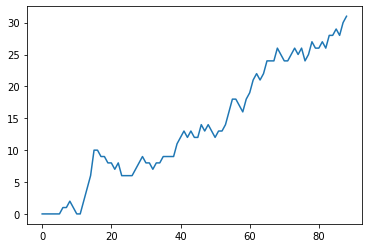

In [14]:
plt.plot(no_jobs_waiting)

plt.show()

In [15]:
process_time  = []
waiting_time = []
net_time = []
for job in job_queue:
    if job_queue[job]['status_flag'][0]:
        waiting_time.append(job_queue[job]['entry_time'][0] - job_queue[job]['arrival_time'][0])
        process_time.append(job_queue[job]['exit_time'][0] - job_queue[job]['entry_time'][0])
        net_time.append(job_queue[job]['exit_time'][0] - job_queue[job]['arrival_time'][0])

print("Mean Waiting Time: ", np.mean(waiting_time), "sec")
print("Mean Process Time: ", np.mean(process_time), "sec")
print("Mean Net Time: ", np.mean(net_time), "sec")
    

Mean Waiting Time:  11.586952577203007 sec
Mean Process Time:  13.824381064560454 sec
Mean Net Time:  25.41133364176346 sec
tensor([[-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        ...,
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06]], device='cuda:1', grad_fn=<AddmmBackward>)
Mean time taken: 46.11022472381592
tensor([[-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-06,
         -2.7446e-06, -2.7446e-06],
        [-2.7446e-06, -2.7446e-06, -2.7446e-06,  ..., -2.7446e-0